<a href="https://www.kaggle.com/code/sinjeongyeol/spaceshiptitanic-binaryclassification-2?scriptVersionId=99678258" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# this notebook is improved before 
https://www.kaggle.com/code/sinjeongyeol/spaceshiptitanic-binaryclassification-1/notebook
notebook

## plus skill
### Target encoding with smoothing
### Add feature
### optimize hyperparameter

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [3]:
feats_cat = []
feats_num = []
for col in train.columns:
    if col in ['PassengerId', 'Transported']:
        continue
    if train[col].dtype == 'object':
        feats_cat += [col]
    else:
        feats_num += [col]
        
feats_cat, feats_num

(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'],
 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [4]:
train_len = len(train)
dataset = pd.concat([train, test], axis=0).reset_index(drop=True)

In [5]:
dataset.shape, train.shape, test.shape

((12970, 14), (8693, 14), (4277, 13))

### PassengerId
### Add group_cnt, group_num

In [6]:
train['PassengerId']

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

In [7]:
dataset['group_id'] = 0
dataset['group_num'] = 0
for i in range(len(dataset)):
    group_id, id_at_group = map(int, dataset.iloc[i]['PassengerId'].split('_'))
    dataset.loc[i, 'group_id'] = group_id
    dataset.loc[i, 'group_num'] = id_at_group

In [8]:
dataset = pd.merge(dataset, dataset[['group_id', 'PassengerId']].groupby('group_id').count().reset_index().rename(columns={'PassengerId': 'group_cnt'}), how='left', on='group_id')
dataset = dataset.drop('group_id', axis=1)
dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_num,group_cnt
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1


In [9]:
feats_num += ['group_num', 'group_cnt']

<AxesSubplot:>

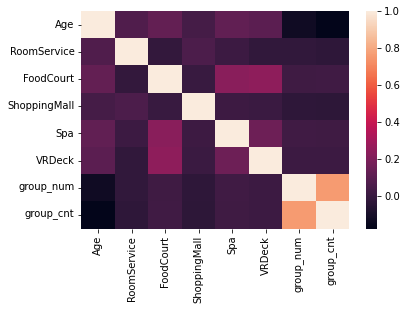

In [10]:
import seaborn as sns

corr = dataset[feats_num].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

<AxesSubplot:xlabel='group_cnt', ylabel='count'>

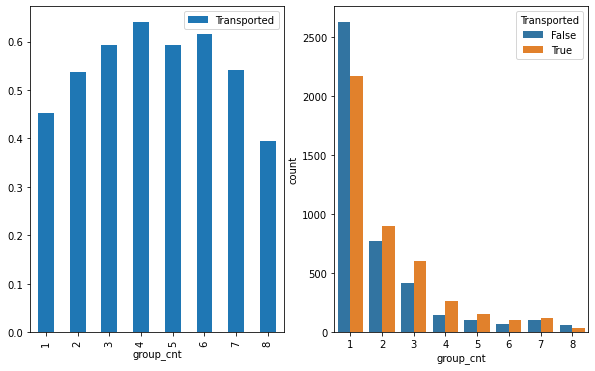

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['group_cnt', 'Transported']].groupby('group_cnt').mean().plot.bar(ax=ax[0])
sns.countplot(x='group_cnt', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

<AxesSubplot:xlabel='group_num', ylabel='count'>

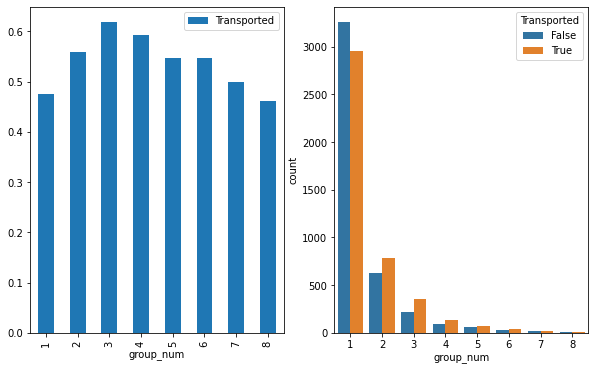

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
dataset[dataset['Transported'].notnull()][['group_num', 'Transported']].groupby('group_num').mean().plot.bar(ax=ax[0])
sns.countplot(x='group_num', data=dataset[dataset['Transported'].notnull()], hue='Transported', ax=ax[1])

#### I'll add this features and decide whether to add it or not after seeing feature importance 